# Explanation script
### Doris van Uffelen 31-10-2021

In this script a location for a market square is found in our plot. It uses an example grid and not the actual size of the grid for clarity. 
First, a base grid, with the functions placed before is used for creating the needed contextual information. Then, the voxels of the square
are placed one by one. Each time the script runs, a different possible outcome is generated.

## Import and install
All needed libraries are imported and installed.

## Plot maps
Consists of functions that can later be used to plot the lattices

## Setting the base grid
An example grid is manually filled in, to use as base and information for the rest of the grid.
This can be exchanged by input from the actual grid.
Also a lattice is made for all free space.

## Find neighbours
A neumann stencil is created for finding neighbours.
Then a function is written for finding neighbours.

A lattice is made with all voxels next to a road, the function and stencil for finding neighbours are used.
A lattice is made with all voxels not next to a road, the function and stencil for finding neighbours are used.

## Find location for square
Function for choosing 1 random possible location out of a list.
Function for finding direct neighbours.

A location for the square is found by placing each voxel one by one after each other.
All voxels have their own conditions.

There are multiple possibilities, each time the plot runs it finds a new location.

# import and install

In [75]:
# !python -m pip install -e ../topogenesis

In [76]:
# importing NumPy and NetworkX for working with graphs
import numpy as np
import networkx as nx

# importing topogenesis for working with lattices / regular-grids
import topogenesis as tg

# importing pyvista for visualizations
import pyvista as pv

# importing Pandas and display for clearer representation of table data and matrices
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt

# Plot maps

In [77]:
# function for printing grids with custom color maps

def image(base_lattice, color_map):
    # Change the shape of the lattice so only the groundfloor is plotted
    lattice = np.copy(base_lattice)
    lattice.transpose(1, 0, 2)
    color_lattice = lattice[:, 1, :]

    # Add custom color map
    image = np.array([[color_map[val] for val in row] for row in color_lattice], dtype='int')
    return plt.imshow(image)

In [78]:
# define color map 
color_map = {0: np.array([255, 255, 255]), # white
             2: np.array([152, 141, 96]), # green/grey
             3: np.array([178, 192, 163]), # light grey
             4: np.array([70, 83, 99]), # dark blue
             5: np.array([199, 143, 82])} # orange

In [79]:
#  function for printing grids with only 0 and 1

def boolean_image(base_lattice):
    # Change the shape of the lattice so only the groundfloor is plotted
    lattice = np.copy(base_lattice)
    lattice.transpose(1, 0, 2)
    color_lattice = lattice[:, 1, :]
    
    return plt.imshow(color_lattice, "Greens")

# setting the base grid

In [80]:
# Functions:

Functions = { 
    "empty" : 0,
    "water" : 1,
    "road" : 2,
    "souk" : 3,
    "well" : 4,
    "square" : 5,
    "Water workshop" : 6,
    "non-water workshop" : 7,
    "shop" : 8,
    "house" : 9}


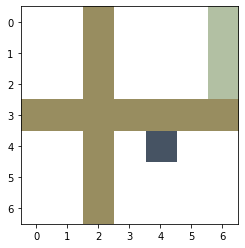

In [81]:
# Define the grid 
len_x = 7
len_y = 7
len_z = 3

# length and width of matrix
len_grid = len_y, len_z, len_x
# Initialize the empty matrix
base_grid = np.zeros(len_grid, dtype=int)

# place water
base_grid[4, 2, :] = 1

# place main road
base_grid[3, 1, :] = 2
base_grid[:, 1, 2] = 2

# place souk
base_grid[:3, 1, 6] = 3

# place well
base_grid[4, 1, 4] = 4

original_base_lattice = tg.to_lattice(base_grid, minbound=0, unit=1)
image(original_base_lattice, color_map)

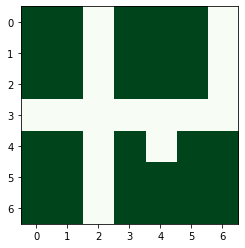

In [82]:
# Find all voxels without functions and mark them with 1, all locations with functions become 0
bool_base_lattice = (original_base_lattice > 0).astype(int)
free_space_lattice = 1 - bool_base_lattice

boolean_image(free_space_lattice)

# Find neighbours

## create neighbour stencil

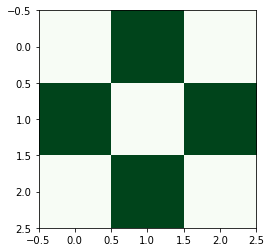

In [83]:
# creating neuman neighborhood definition
neumann_stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center and -1 and 1 floor to zero
neumann_stencil[1,:,1] = 0

boolean_image(neumann_stencil)

## function for finding neighbours

In [84]:
# main loop for breath-first traversal
def dist_lattice(index_func,neighs,max_dist, base_lattice):
    func_lattice = base_lattice == index_func
    func_neighs_lattice = 1 - func_lattice
    func_neighs_lattice[func_neighs_lattice == 1] = max_dist
    dist_lattice_flat = func_neighs_lattice.flatten()

    for i in range(1, max_dist):
        # find the neighbours of the previous step
        next_step = neighs[dist_lattice_flat == i - 1]
        # make a copy of the lattice to prevent overwriting in the memory
        next_dist_lattice_flat = np.copy(dist_lattice_flat)
        # set the next step cells to the current distance
        next_dist_lattice_flat[next_step.flatten()] = i
        # find the minimum of the current distance and previous distances to avoid overwriting previous steps
        dist_lattice_flat = np.minimum(dist_lattice_flat, next_dist_lattice_flat)
        
        # check how many of the cells have not been traversed yet
        filled_check = dist_lattice_flat == max_dist
        # if all the cells have been traversed, break the loop
        if filled_check.sum() == 0:
            print(i)
            break

    # reshape and construct a lattice from the street network distance list
    dist_lattice = dist_lattice_flat.reshape(base_lattice.shape)

    return dist_lattice

## find voxels next to streets

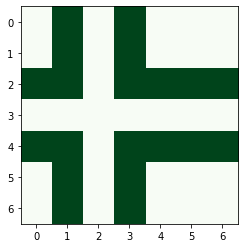

In [85]:
# input neighs function
neighs_streets = original_base_lattice.find_neighbours(neumann_stencil)
max_dist = np.sum(original_base_lattice.shape)
index_street = 2

# find neighbours of the streets
street_neigh_lattice = dist_lattice(index_street,neighs_streets,max_dist, original_base_lattice)
street_neigh_lattice[street_neigh_lattice >= 2] = 0
street_neigh_lattice[street_neigh_lattice == 1] = max_dist

boolean_image(street_neigh_lattice)

## find voxels not next to streets

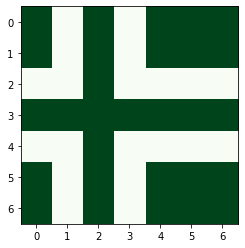

In [86]:
# Using input from previous street_dist_lattice invert lattice to find all locations not next to a road
street_no_neigh_lattice = np.copy(street_neigh_lattice)
street_no_neigh_lattice[street_no_neigh_lattice == 0] = 1
street_no_neigh_lattice[street_no_neigh_lattice == max_dist] = 0

boolean_image(street_no_neigh_lattice)

# find location for square

In [87]:
def locate_func(func_dist_lattice):
    # Find location
    possible_locations = np.flatnonzero(func_dist_lattice == np.max(func_dist_lattice))
    best_location = np.random.choice(possible_locations , size = None, replace = False, p = None)
    return best_location

def voxel_neigh_lattice(best_location):
    # make empty lattice
    voxel_grid = np.zeros(original_base_lattice.shape, dtype=int)
    voxel_lattice = tg.to_lattice(voxel_grid, minbound=0, unit=1)
    np.put(voxel_lattice, [best_location], [1])

    # find neighbours
    neighs_voxel = voxel_lattice.find_neighbours(neumann_stencil)
    max_dist = np.sum(voxel_lattice.shape)
    voxel_neigh_lattice = dist_lattice(1,neighs_voxel,max_dist,voxel_lattice)
    voxel_neigh_lattice[voxel_neigh_lattice >= 2] = 0
    voxel_neigh_lattice[voxel_neigh_lattice == 1] = 2
    return voxel_neigh_lattice

[8, 29, 28, 7]


c:\users\doris\documents\bt3\earthy\w3_graphs_fields\topogenesis\topogenesis\datastructures\datastructures.py:1107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounds = np.array([minbound, minbound + unit * (np.array(a.shape) - 1)])
c:\users\doris\documents\bt3\earthy\w3_graphs_fields\topogenesis\topogenesis\datastructures\datastructures.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounds = np.array([minbound, maxbound])*unit


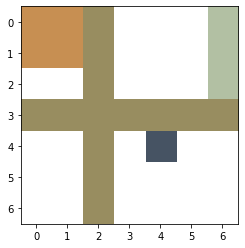

In [90]:
# locate first voxel of square
func_dist_lattice = street_neigh_lattice * free_space_lattice
first_voxel = locate_func(func_dist_lattice)

# find neighboours of first voxel
first_voxel_neigh_lattice = voxel_neigh_lattice(first_voxel)


# locate second voxel
func_dist_lattice = first_voxel_neigh_lattice * street_neigh_lattice * free_space_lattice
second_voxel = locate_func(func_dist_lattice)

# find neighboours of second voxel
second_voxel_neigh_lattice = voxel_neigh_lattice(second_voxel)


# locate third voxel
func_dist_lattice  = second_voxel_neigh_lattice * street_no_neigh_lattice * free_space_lattice
third_voxel = locate_func(func_dist_lattice)

# find neighboours of third voxel
third_voxel_neigh_lattice = voxel_neigh_lattice(third_voxel)


# locate fourth voxel
func_dist_lattice = first_voxel_neigh_lattice * third_voxel_neigh_lattice * street_no_neigh_lattice * free_space_lattice
fourth_voxel = locate_func(func_dist_lattice)


# Add voxels to list
indeces_square = []
indeces_square.append(first_voxel) 
indeces_square.append(second_voxel) 
indeces_square.append(third_voxel) 
indeces_square.append(fourth_voxel) 

# place squares in lattice
square_lattice = np.copy(original_base_lattice)
np.put(square_lattice, indeces_square, 5)

print(indeces_square)
image(square_lattice, color_map)
